<a href="https://colab.research.google.com/github/MickGuillen/Challenge2-Data-Science/blob/main/Telecom_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalación y Librerías**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuraciones visuales
pd.set_option('display.max_columns', None)
sns.set_theme(style="darkgrid")
sns.set_palette('husl')

# **Carga y Unión de Datos**

In [ ]:
print("🔄 Descargando y uniendo datasets desde GitHub...")

urls = [
    "https://raw.githubusercontent.com/MickGuillen/Challenge2-Data-Science/main/base-de-datos-challenge2/tienda_1%20.csv",
    "https://raw.githubusercontent.com/MickGuillen/Challenge2-Data-Science/main/base-de-datos-challenge2/tienda_2.csv",
    "https://raw.githubusercontent.com/MickGuillen/Challenge2-Data-Science/main/base-de-datos-challenge2/tienda_3.csv",
    "https://raw.githubusercontent.com/MickGuillen/Challenge2-Data-Science/main/base-de-datos-challenge2/tienda_4.csv"
]

dfs = [pd.read_csv(url) for url in urls]
df = pd.concat(dfs, ignore_index=True)

print(f"Datos combinados: {df.shape} filas y columnas")
df.head()

🔄 Descargando y uniendo datasets desde GitHub...
Datos combinados: (9435, 12) filas y columnas


,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


# **Limpieza y Preparación**

In [13]:
# Estandariza nombres (opcional)
df.columns = df.columns.str.strip().str.lower()

print("Columnas disponibles:", df.columns.tolist())

# Variable objetivo elegida
target_col = 'categoría del producto'

if target_col not in df.columns:
    raise ValueError(f"Columna objetivo '{target_col}' no encontrada en el dataset.")

X = df.drop(target_col, axis=1)
y = df[target_col]

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

print(f"Categóricas: {cat_cols}")
print(f"Numéricas: {num_cols}")

Columnas disponibles: ['producto', 'categoría del producto', 'precio', 'costo de envío', 'fecha de compra', 'vendedor', 'lugar de compra', 'calificación', 'método de pago', 'cantidad de cuotas', 'lat', 'lon']
Categóricas: ['producto', 'fecha de compra', 'vendedor', 'lugar de compra', 'método de pago']
Numéricas: ['precio', 'costo de envío', 'calificación', 'cantidad de cuotas', 'lat', 'lon']


# **División Entrenamiento y Test**

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Supongo que tu DataFrame ya está cargado en 'df'
# Ejemplo:
# df = pd.read_csv('tu_archivo.csv')

# Normaliza nombres de columnas: quita espacios y pasa a minúsculas
df.columns = df.columns.str.strip().str.lower()

print("Columnas disponibles:", df.columns.tolist())

# Define la variable objetivo
target_col = 'categoría del producto'

if target_col not in df.columns:
    raise ValueError(f"Columna objetivo '{target_col}' no encontrada en el dataset.")

# Define variables predictoras y objetivo
X = df.drop(target_col, axis=1)
y = df[target_col]

# Divide el dataset en train y test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Tamaño entrenamiento: {X_train.shape}")
print(f"Tamaño prueba: {X_test.shape}")


Columnas disponibles: ['producto', 'categoría del producto', 'precio', 'costo de envío', 'fecha de compra', 'vendedor', 'lugar de compra', 'calificación', 'método de pago', 'cantidad de cuotas', 'lat', 'lon']
Tamaño entrenamiento: (6604, 11)
Tamaño prueba: (2831, 11)


# **Definición de Pipeline con SMOTE**

In [16]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Asumiendo que X ya está definido (variables predictoras)
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
    ])

models = {
    'LogReg': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

pipelines = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    pipelines[name] = pipe


# **Entrenamiento**

In [17]:
# Asegúrate que df está cargado aquí
df.columns = df.columns.str.strip().str.lower()

target_col = 'categoría del producto'
X = df.drop(target_col, axis=1)
y = df[target_col]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
])

models = {
    'LogReg': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

pipelines = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    pipelines[name] = pipe

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    print(f"{name} entrenado.")


LogReg entrenado.
RandomForest entrenado.


# **Evaluación**


Modelo: LogReg
                         precision    recall  f1-score   support

Artículos para el hogar       1.00      1.00      1.00       219
   Deportes y diversión       1.00      1.00      1.00       334
      Electrodomésticos       1.00      1.00      1.00       345
           Electrónicos       1.00      1.00      1.00       532
 Instrumentos musicales       1.00      1.00      1.00       226
               Juguetes       1.00      1.00      1.00       387
                 Libros       1.00      1.00      1.00       222
                Muebles       1.00      1.00      1.00       566

               accuracy                           1.00      2831
              macro avg       1.00      1.00      1.00      2831
           weighted avg       1.00      1.00      1.00      2831

Matriz de confusión:
[[219   0   0   0   0   0   0   0]
 [  0 334   0   0   0   0   0   0]
 [  0   0 345   0   0   0   0   0]
 [  0   0   0 532   0   0   0   0]
 [  0   0   0   0 226   0   0   0]
 [  0

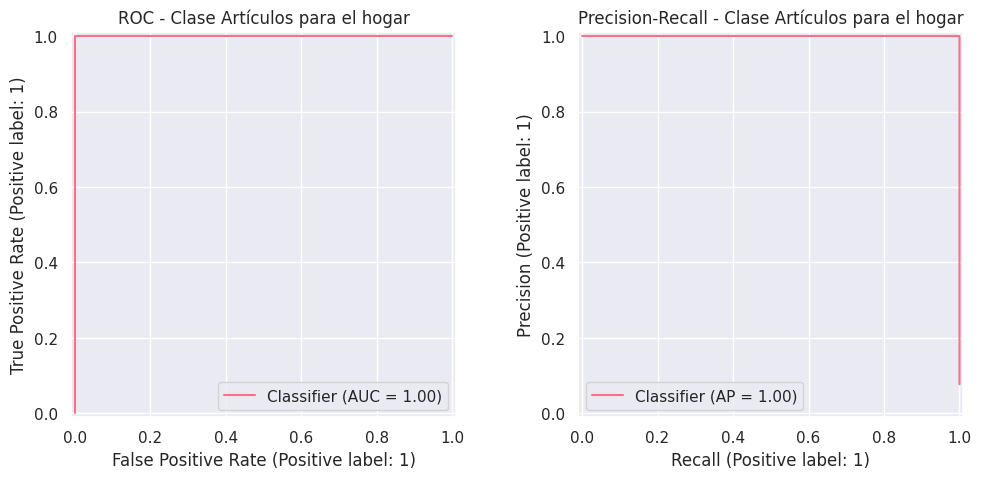

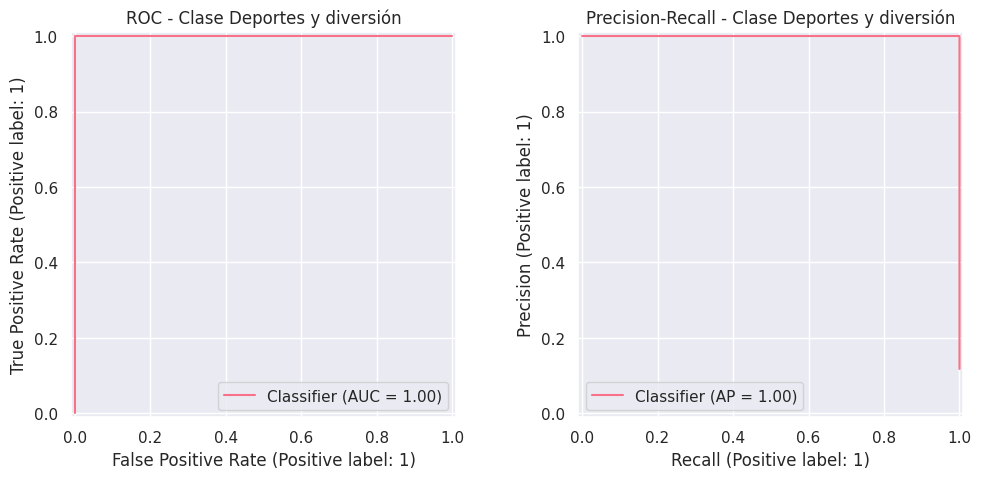

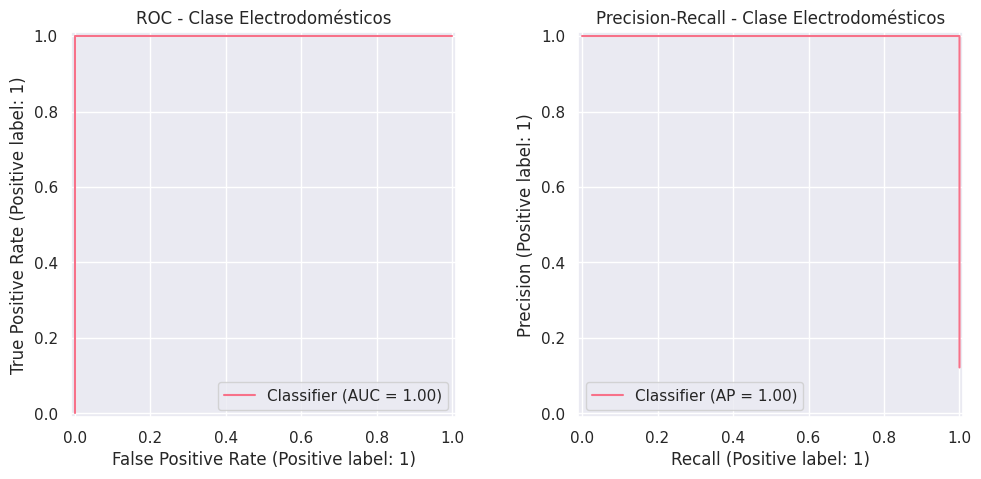

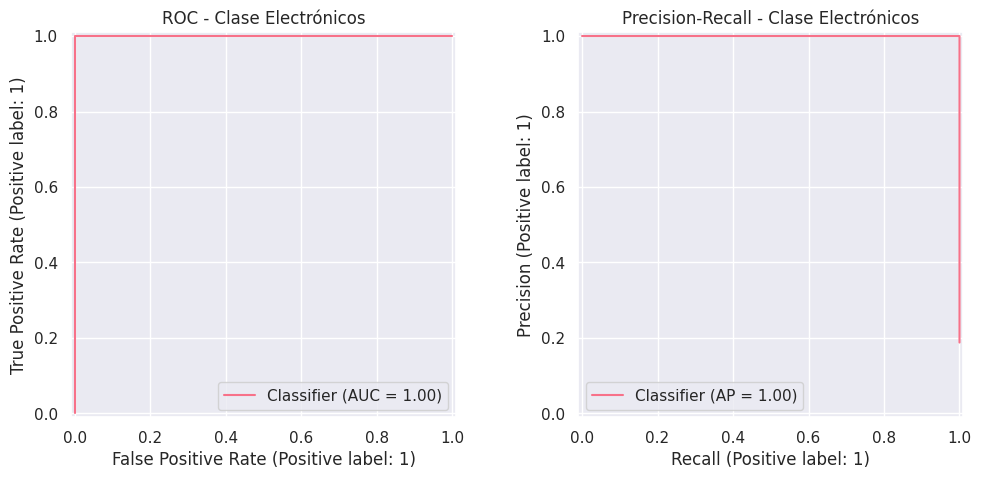

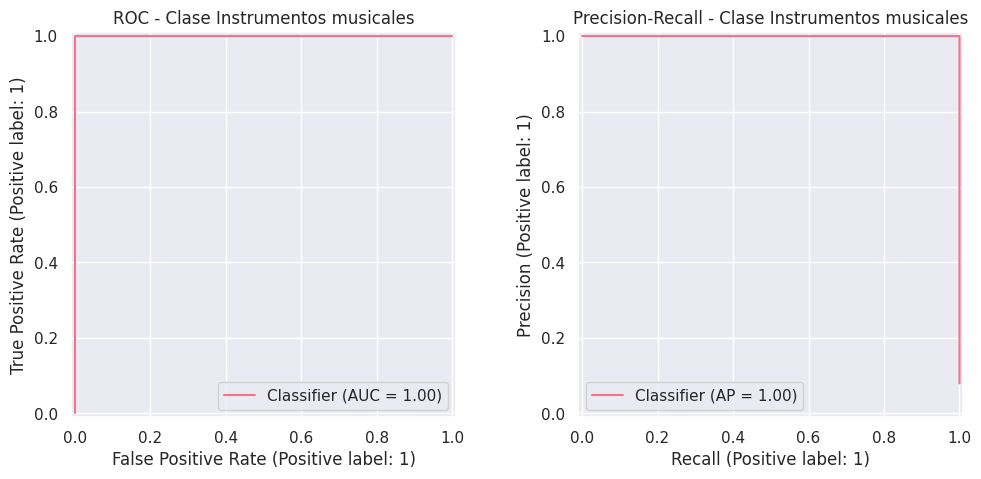

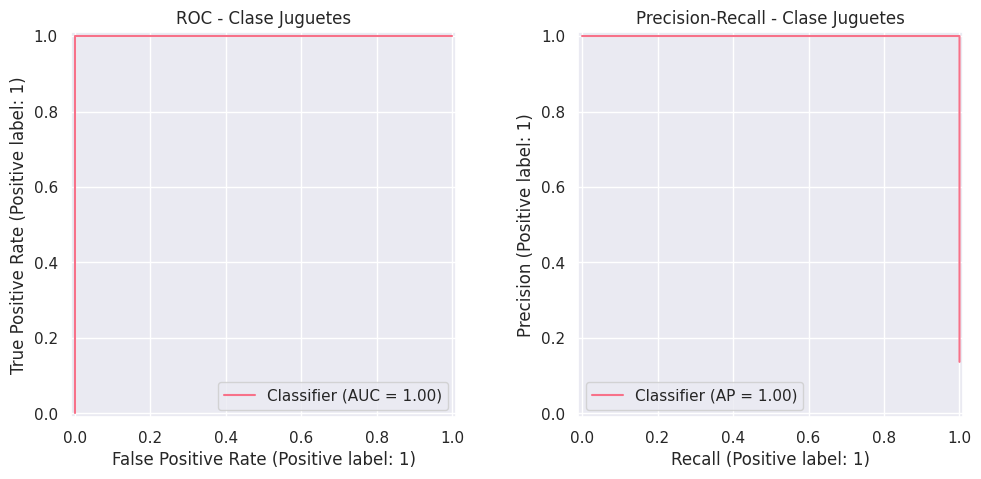

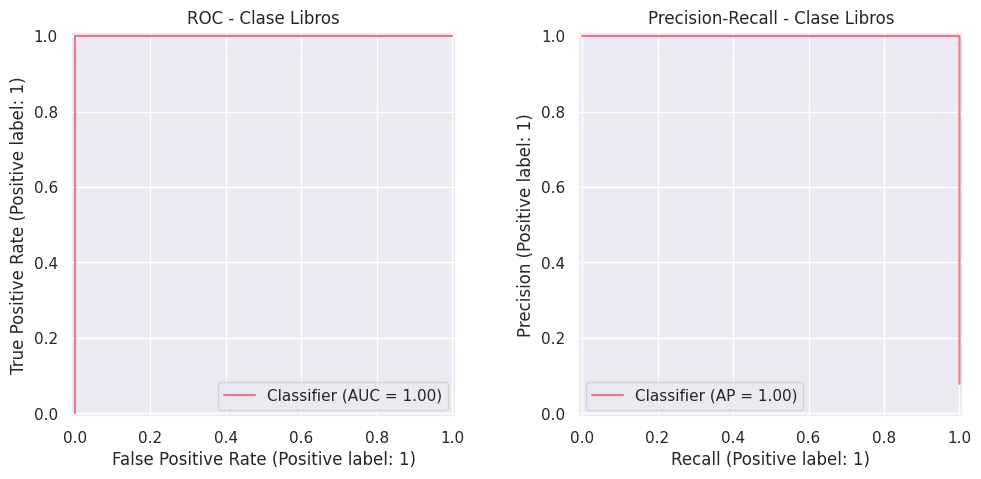

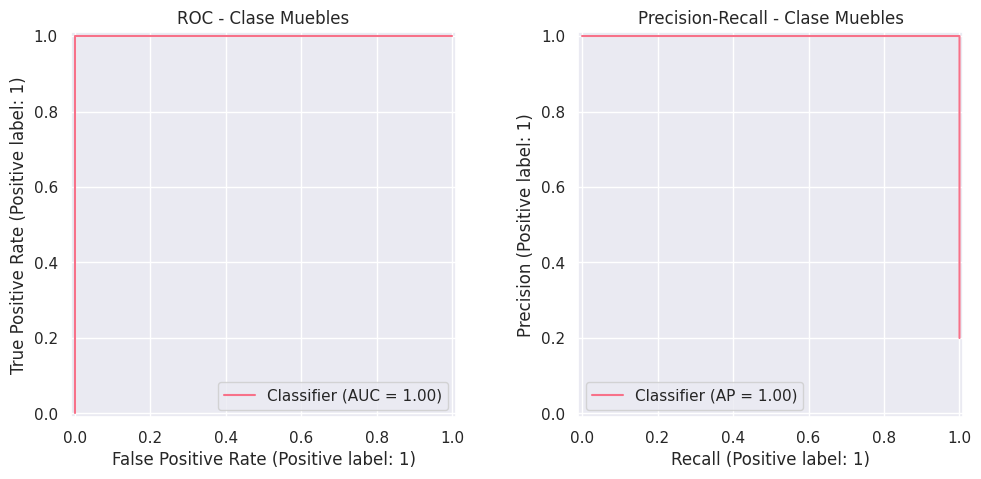


Modelo: RandomForest
                         precision    recall  f1-score   support

Artículos para el hogar       1.00      1.00      1.00       219
   Deportes y diversión       1.00      1.00      1.00       334
      Electrodomésticos       1.00      1.00      1.00       345
           Electrónicos       1.00      1.00      1.00       532
 Instrumentos musicales       1.00      1.00      1.00       226
               Juguetes       1.00      1.00      1.00       387
                 Libros       1.00      1.00      1.00       222
                Muebles       1.00      1.00      1.00       566

               accuracy                           1.00      2831
              macro avg       1.00      1.00      1.00      2831
           weighted avg       1.00      1.00      1.00      2831

Matriz de confusión:
[[219   0   0   0   0   0   0   0]
 [  0 334   0   0   0   0   0   0]
 [  0   0 345   0   0   0   0   0]
 [  0   0   0 532   0   0   0   0]
 [  0   0   0   0 226   0   0   0]

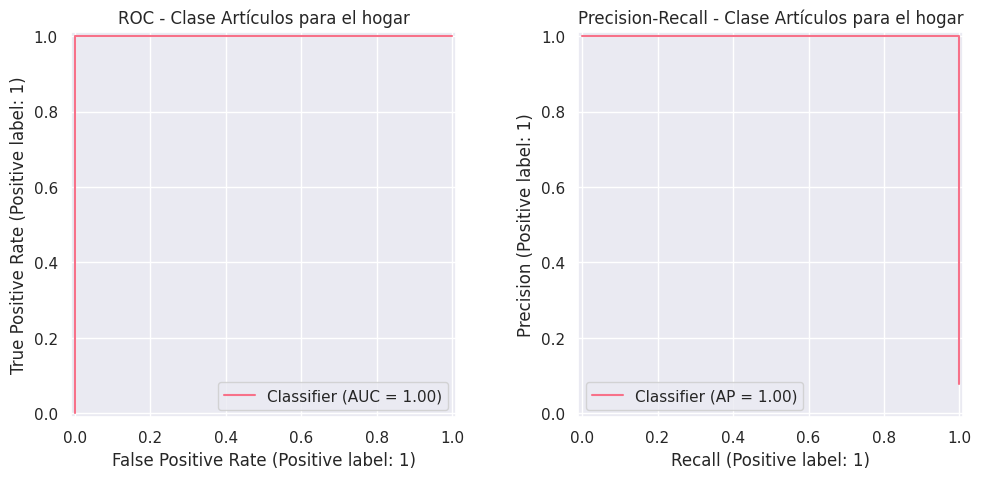

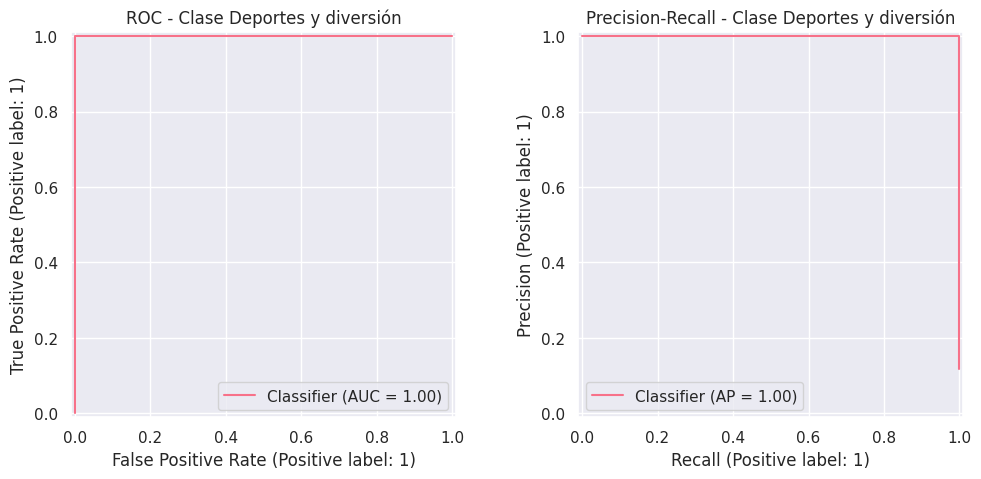

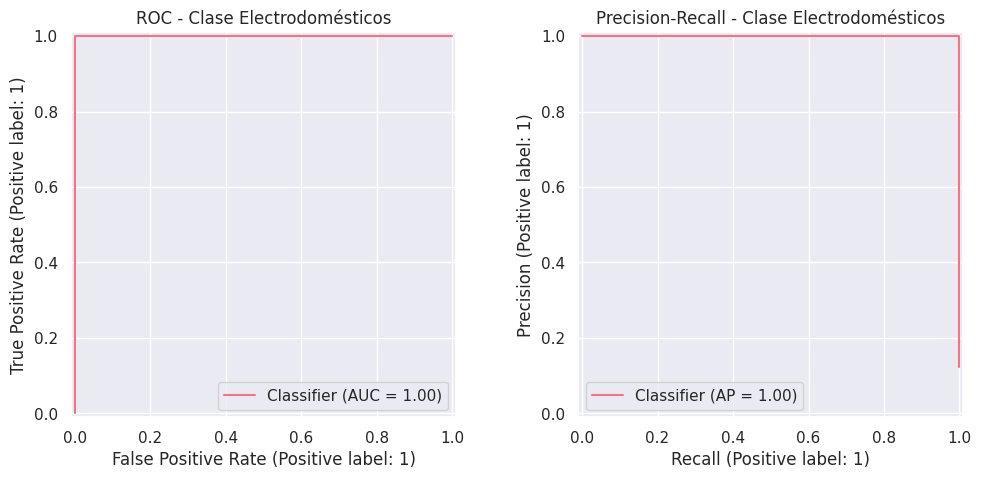

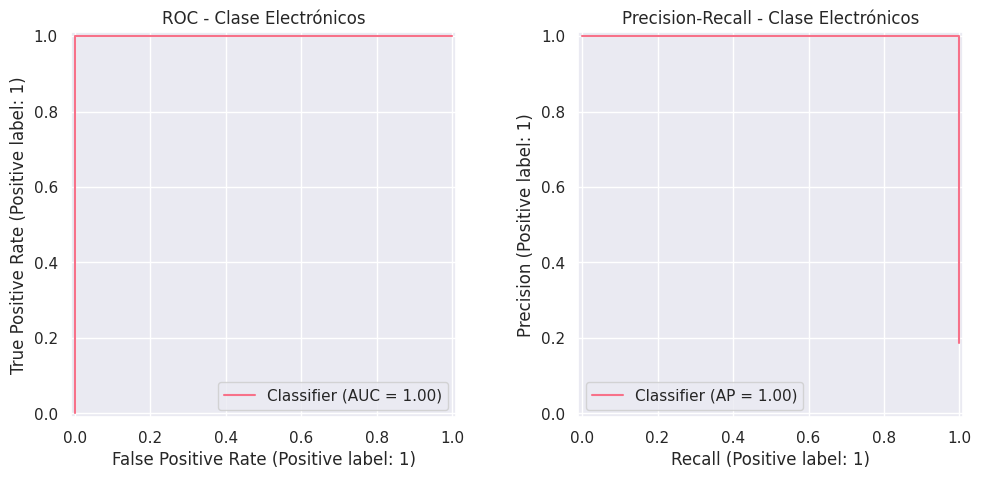

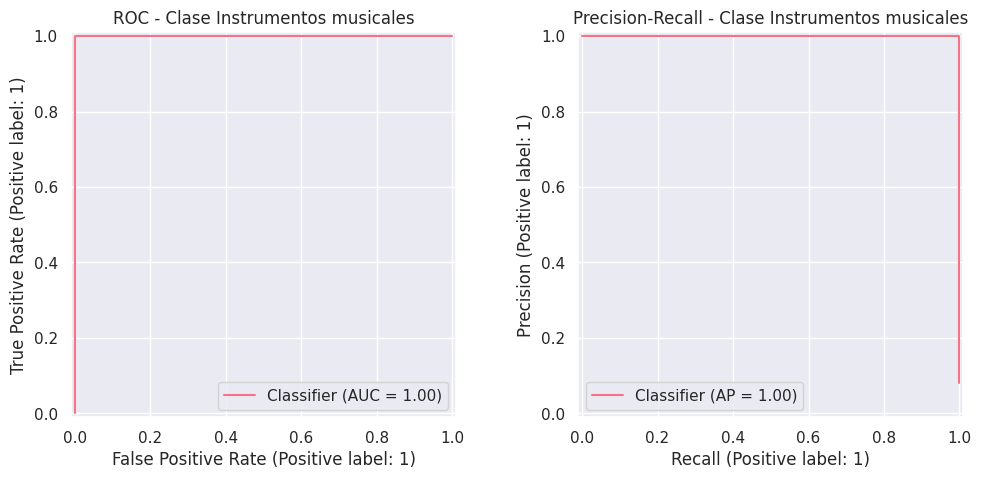

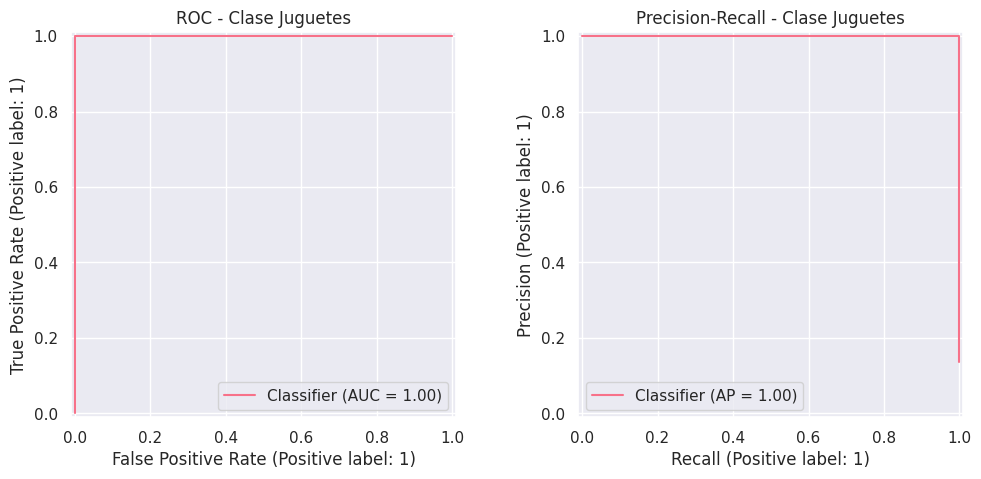

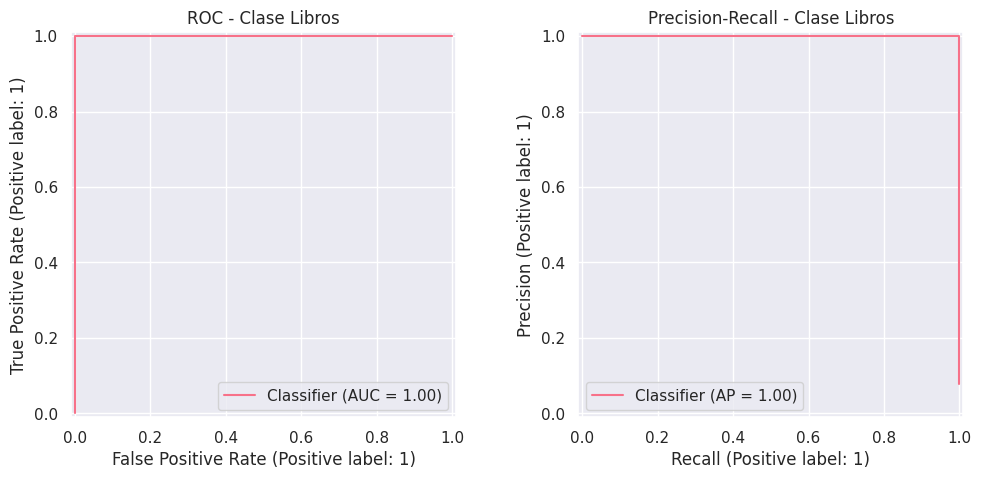

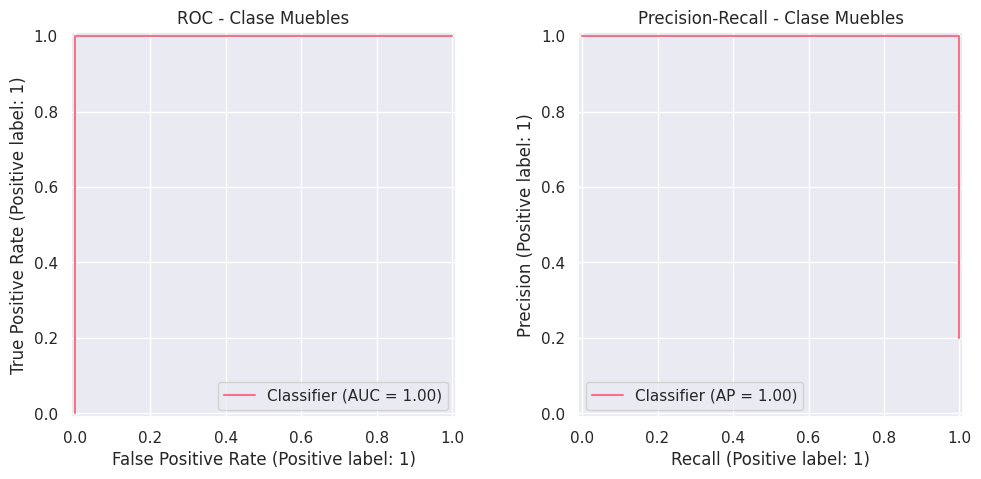

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

def evaluate_model_multiclass(name, pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)

    print(f"\nModelo: {name}")
    print(classification_report(y_test, y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))

    # Binarizar las etiquetas para multiclasificación
    classes = pipe.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        RocCurveDisplay.from_predictions(y_test_bin[:, i], y_prob[:, i], ax=axs[0])
        axs[0].set_title(f'ROC - Clase {classes[i]}')

        PrecisionRecallDisplay.from_predictions(y_test_bin[:, i], y_prob[:, i], ax=axs[1])
        axs[1].set_title(f'Precision-Recall - Clase {classes[i]}')

        plt.show()

# Luego ejecuta:
for name, pipe in pipelines.items():
    evaluate_model_multiclass(name, pipe, X_test, y_test)



# **Importancia de Variables (Random Forest)**

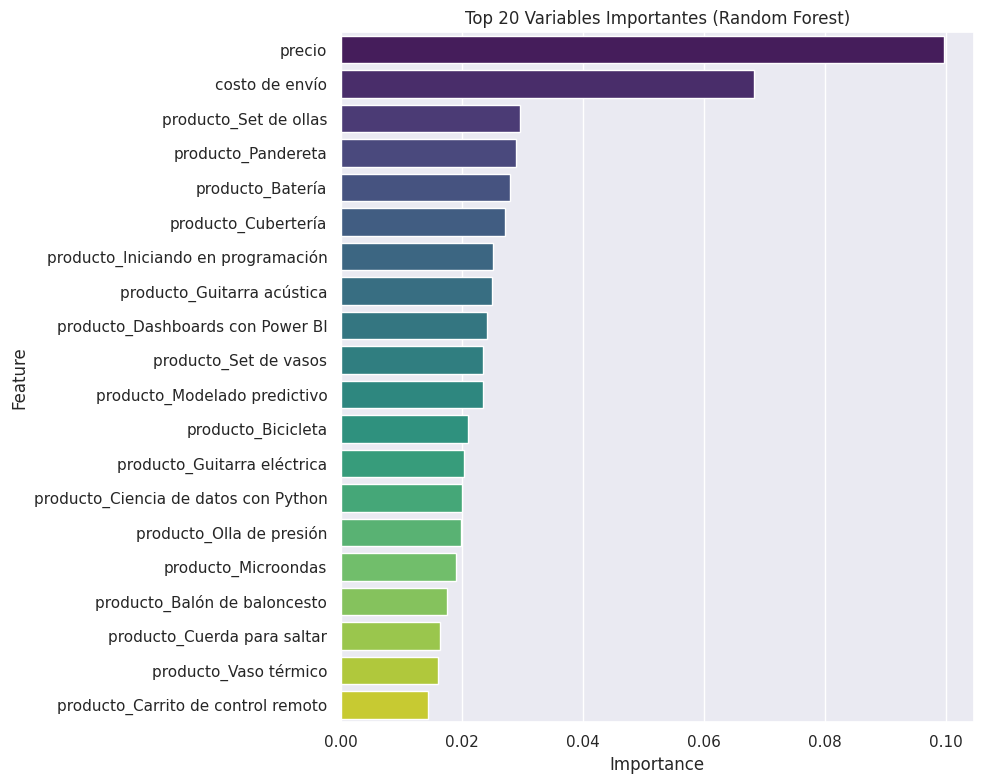

In [20]:
# Definir columnas categóricas y numéricas a partir de X
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

# Extraer el OneHotEncoder del pipeline Random Forest
ohe = pipelines['RandomForest'].named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(cat_cols)

all_features = num_cols + list(ohe_features)

importances = pipelines['RandomForest'].named_steps['classifier'].feature_importances_

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Top 20 Variables Importantes (Random Forest)')
plt.tight_layout()
plt.show()


# **Guardar Modelos y Resultados**

In [21]:
import joblib

for name, pipe in pipelines.items():
    joblib.dump(pipe, f"{name.lower()}_model.joblib")
    print(f"Guardado: {name.lower()}_model.joblib")

feat_imp.to_csv('feature_importance.csv', index=False)
print("Guardado: feature_importance.csv")


Guardado: logreg_model.joblib
Guardado: randomforest_model.joblib
Guardado: feature_importance.csv
